# Snapchat Political Ads
* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    * Predict the reach (number of views) of an ad.
    * Predict how much was spent on an ad.
    * Predict the target group of an ad. (For example, predict the target gender.)
    * Predict the (type of) organization/advertiser behind an ad.

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings


### Introduction
In this project, we continue the research problems in project 3, but this time, we focus on prediction problem. At here, we try to predict how much was spent on an advertisement. We would like to utilize different features in the dataframe such as **Impressions**, **OrganizationName**, and **PayingAdvertiserName**. By combining these different features, we would like to build regression models in the project, so the problem is regression problem. The target variable is **Spend**. We try to utilize different features in the dataframe to predict the spend of advertisements. For the baseline model, we consider the spend might be related to **Impressions**, **OrganizationName**, and **PayingAdvertiserName**. In the final model, we add more information by engineering features such as **StartDate** and **CountryCode**. 

Our evaluation metric that is used for two models is mean absolute error. It could help us to clearly see the differences between predictions and actual values. By comparing the mean absolute errors of different models, we could figure out the best model which generates the perdictions that are closest to actual values.


### Baseline Model
For the baseline model, we choose three features in the dataset: **Impressions** (quantitative), **OrganizationName** (nominal), and **PayingAdvertiserName** (nominal). We think these features are closely related to the spend of ads. The spends may influence the popularity of ads, which could be reflected by the data of impressions. Also, the organizations and advertisers that posted the ads may impact the spends, since different organizations and individuals spend different amount of money on ads.

In this part, we make four predictions. For the first three predictions, we use **Impressions**, **OrganizationName**, and **PayingAdvertiserName** separately to predict spends. We measure the performance by mean absolute error. It turns out that the mean absolute errors of these three predictions were large. Then we use all of the three features above to make the prediction. The performance improve, but still unsatisfactory. Therefore, we think that our model is not good. The features we used are one-sided, because we fail to comprehensively include the influencing factors, such as information about countries and dates.

### Final Model
In the model, we add **Currency Code**, **StartDate**, **Gender**, **CountryCode**, and **AgeBracket** as new features we utilized and also the combination of these features. For **StartDate**, we utilized feature engineering to extract only year and month from regular StartDate. For **CountryCode**, we utilized feature engineering to classify different countries into different continents, which become easier for us to perform OneHotEncoding. For **AgeBracket**, we utilized feature engineering to caculcate the minimum age of AgeBracket. So far we have not known whether these features are helpful or not. we think these four features are good for data for many reasons. For **Currency Code**, we think the spends has relationship with it since different currency represents different country and we could predict the spends according to the richness of one country. Same mechanism of Currency code works in **CountryCode**. For the **StartDate**, we think different month and year could influence the money that organization spend. For **Gender**, we think the spent money could correlated with gender. 

The final model is a regression model to predict the spends on ads. In order to figure out the best features, we try five different combinations of features for predictions. First, we utilize the combination of **Impressions**, **OrganizationName**, **PayingAdvertiserName**, and **Currency Code**. The result shows that the currency code feature improves the performace and leads to smaller mean absolute error than the prediction in our baseline model. Same thing happens when we try to use **StartDate** and **CountryCode** -- they could improve the model. However, when we try to use **Gender**, we find out that this feature actually make the model become worse. The mean absolute error is larger than that of baseline model. Therefore, we could conclude that **Gender** is bad for the model and prediciton. Then, same things happens on **AgeBracket** -- it is bad for the model. Last, we combine features that could improve our model -- **Impressions**, **OrganizationName**, **PayingAdvertiserName**, **Currency Code**, **StartDate**, and **CountryCode**. As a result, the combination of these features has the lowest mean absolute error, which is the best for our model.



### Fairness Evaluation
For this part, we evaluate the fairness of our model by a permutation test. First, we split the data into two groups based on the data in **Impressions**. After getting the median of impressions, we decide to use 75000 as a dividing point. If an ad has more than 75000 impressions, then it belongs to "large" group; otherwise, it belongs to "small" group. We want to figure out whether the distributions of the r2-scores are similar for large and small groups. The r2-score could help us to determine the prediction that is closest to the actual value.

**Null Hypothesis**: The distributions of r2-scores for large and small groups are similar. <br>
**Alternative Hypothesis**: No, the distributions of r2-scores for large and small groups are not similar. <br>
The significant level is 0.05.

Our p-value is around 0.35. Therefore, we cannot reject the null hypothesis. The distributions of r2-scores for large and small groups are similar.

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import sklearn.preprocessing as pp
import sklearn.tree as tr
import sklearn.ensemble as es

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_absolute_error

In [4]:
# Combine and clean the data
infro2 = os.path.join('data', 'PoliticalAds_2019.csv')
df2 = pd.read_csv(infro2)
infro1 = os.path.join('data','PoliticalAds_2018.csv')
df1 = pd.read_csv(infro1)
combined_data = pd.concat([df1,df2],axis = 0).reset_index(drop = True)
combined_data['StartDate'] = pd.to_datetime(combined_data['StartDate'])
combined_data['EndDate'] = pd.to_datetime(combined_data['EndDate'])
combined_data.head()

,ADID,CreativeUrl,Currency Code,Spend,Impressions,StartDate,EndDate,OrganizationName,BillingAddress,CandidateBallotInformation,...,Location Categories (Included),Location Categories (Excluded),Interests,OsType,Segments,Language,AdvancedDemographics,Targeting Connection Type,Targeting Carrier (ISP),CreativeProperties
0,6bf6eca7297551f35a5d17b478cedb6683a75c2f9b9b00...,https://www.snap.com/political-ads/asset/27e1c...,USD,4361,397340,2018-10-18 15:45:57+00:00,2018-11-06 23:00:00+00:00,Bully Pulpit Interactive,"1445 New York Ave NW,Washington,20005,US",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,a801fccc059ac401a54ae3bf309f3b2a22c35df0392666...,https://www.snap.com/political-ads/asset/e1b1d...,USD,11,3309,2018-09-25 05:00:00+00:00,2018-09-26 05:00:00+00:00,ACRONYM,US,NaN,...,NaN,NaN,"Cordcutters,Yoga Enthusiasts,Vegans & Organic ...",NaN,Provided by Advertiser,NaN,NaN,NaN,NaN,web_view_url:https://ourlivesourvote.com/regis...
2,a19bd9f5379e7affc4586d26537346142cc3a8a487b3a3...,https://www.snap.com/political-ads/asset/75251...,USD,205,31789,2018-10-30 17:58:01+00:00,2018-11-06 22:59:59+00:00,Mothership Strategies,"1328 Florida Avenue NW, Building C, Washington...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,web_view_url:http://votingmatters.org/
3,b30c9d008f67f84a14dbb79166f4f1da04d27bea85b3e4...,https://www.snap.com/political-ads/asset/60ab9...,USD,203,94877,2018-09-28 20:33:08+00:00,NaT,Chong and Koster,"1640 Rhode Island Ave. NW, Suite 600,Washingto...",NaN,...,NaN,NaN,NaN,NaN,NaN,en,NaN,NaN,NaN,web_view_url:https://act.everytown.org/sign/di...
4,dfb3bfcd72700889fd7f579bdae86a6c11f2efdede5d78...,https://www.snap.com/political-ads/asset/a72b6...,USD,558,228469,2018-10-09 15:51:44+00:00,2018-11-07 03:00:00+00:00,Penna Powers,"1706 s major street,salt lake city,84115,US",NaN,...,NaN,NaN,NaN,NaN,Provided by Advertiser,NaN,NaN,NaN,NaN,NaN


### Baseline Model

In [392]:
# Extract useful columns
cleaned_data = combined_data[['Spend', 'Impressions', 'OrganizationName', 'PayingAdvertiserName']]

In [393]:
# Regressor of Impressions and Spend
lr = es.RandomForestRegressor()

# Train-test split and fit
X = cleaned_data[['Impressions']]
y = cleaned_data.Spend
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
f = lr.fit(X_train, y_train)

In [394]:
# Mean absolute error for train data
pred = lr.predict(X_train)
scr = mean_absolute_error(y_train, pred)
scr

353.5689988061767

In [395]:
# Mean absolute error for test data
pred_test = lr.predict(X_test)
scr_test = mean_absolute_error(y_test, pred_test)
scr_test

1437.5386875976255

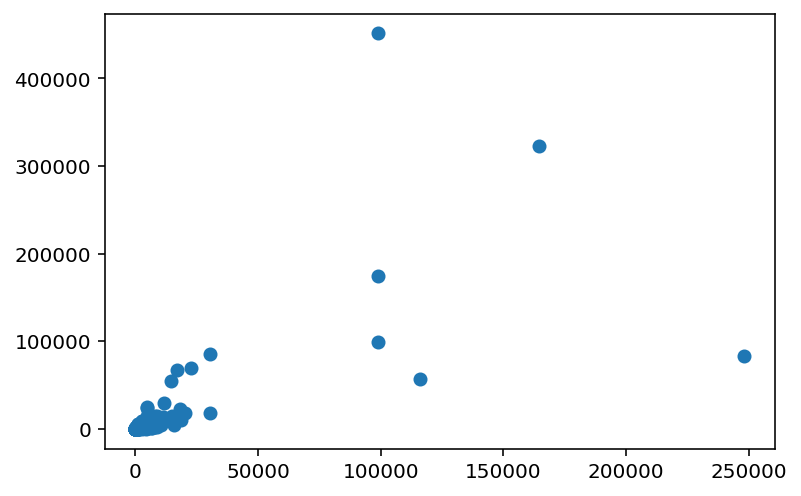

In [396]:
# The scatter plot that shows the relationship between prediction and actual value
plt.scatter(pred_test, y_test)
plt.show()

In [10]:
# Regressor of OrganizationName and Spend
org_feat = Pipeline(steps=[('org', OneHotEncoder(handle_unknown = 'ignore'))])
pl = Pipeline(steps=[('preprocessor', org_feat), ('regressor', es.RandomForestRegressor())])

In [11]:
# Train-test split and fit
X = cleaned_data[['OrganizationName']]
y = cleaned_data.Spend
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
f = pl.fit(X_train, y_train)

In [12]:
# Mean absolute error for train data
pred = pl.predict(X_train)
scr = mean_absolute_error(y_train, pred)
scr

1286.5853183816503

In [13]:
# Mean absolute error for test data
pred_test = pl.predict(X_test)
scr_test = mean_absolute_error(y_test, pred_test)
scr_test

1294.040894962207

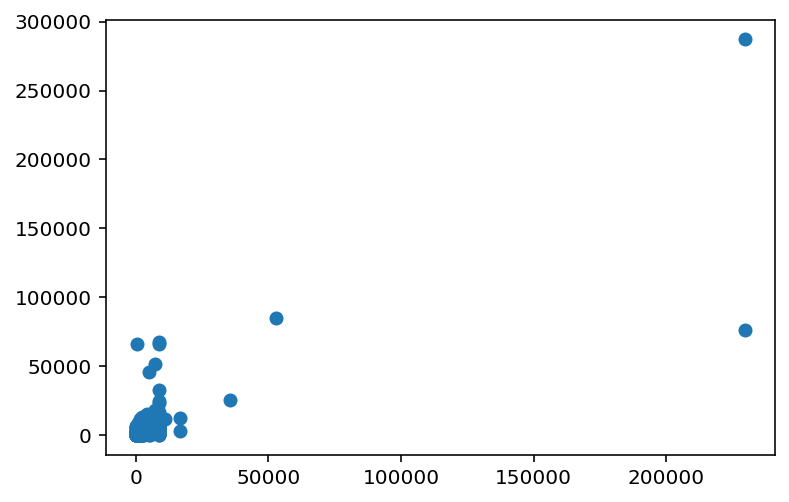

In [14]:
# The scatter plot that shows the relationship between prediction and actual value
plt.scatter(pred_test, y_test)
plt.show()

In [15]:
# Regressor of PayingAdvertiserName and Spend
adv_feat = Pipeline(steps=[('adv', OneHotEncoder(handle_unknown = 'ignore'))])
pl = Pipeline(steps=[('preprocessor', adv_feat), ('regressor', es.RandomForestRegressor())])

In [16]:
# Train-test split and fit
X = cleaned_data[['PayingAdvertiserName']]
y = cleaned_data.Spend
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
f = pl.fit(X_train, y_train)

In [17]:
# Mean absolute error for train data
pred = pl.predict(X_train)
scr = mean_absolute_error(y_train, pred)
scr

1082.028005281689

In [18]:
# Mean absolute error for test data
pred_test = pl.predict(X_test)
scr_test = mean_absolute_error(y_test, pred_test)
scr_test

1653.890314884845

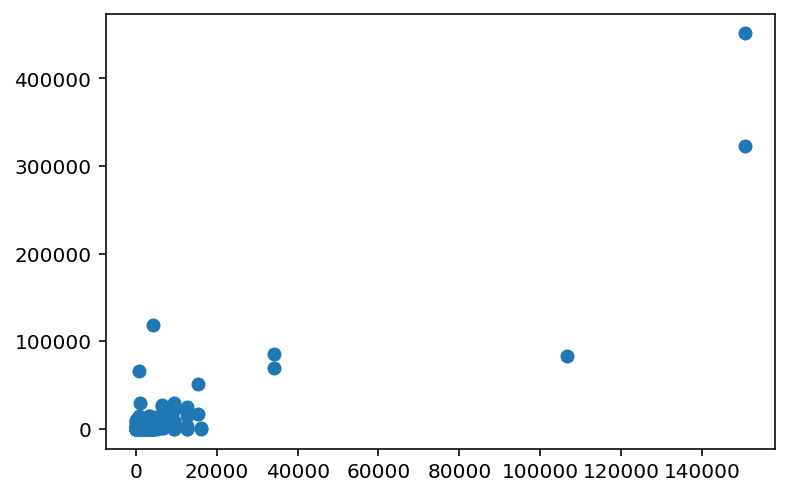

In [19]:
# The scatter plot that shows the relationship between prediction and actual value
plt.scatter(pred_test, y_test)
plt.show()

From the mean absolute errors and scatter plots of the above three predictions, we could see that the errors are pretty large; these are not good predictions.

In [73]:
# Combination of three features
impr = ['Impressions']
impr_trans = Pipeline(steps=[('impr-trans', pp.StandardScaler())])
org = ['OrganizationName']
org_trans = Pipeline(steps=[('org-trans', OneHotEncoder(handle_unknown = 'ignore'))])
adver = ['PayingAdvertiserName']
adver_trans = Pipeline(steps=[('adver-trans', OneHotEncoder(handle_unknown = 'ignore'))])
preproc = ColumnTransformer(transformers=[('impr', impr_trans, impr), ('org', org_trans, org), ('adver', adver_trans, adver)])
pl = Pipeline(steps=[('preprocessor', preproc), ('regressor', es.RandomForestRegressor())])

In [78]:
# Train-test split and fit
X = cleaned_data[['Impressions', 'OrganizationName', 'PayingAdvertiserName']]
y = cleaned_data.Spend
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
f = pl.fit(X_train, y_train)

In [79]:
# Mean absolute error for train data
pred = pl.predict(X_train)
scr = mean_absolute_error(y_train, pred)
scr

286.64308653545766

In [76]:
# Mean absolute error for test data
pred_test = pl.predict(X_test)
scr_test = mean_absolute_error(y_test, pred_test)
scr_test

900.7425760699781

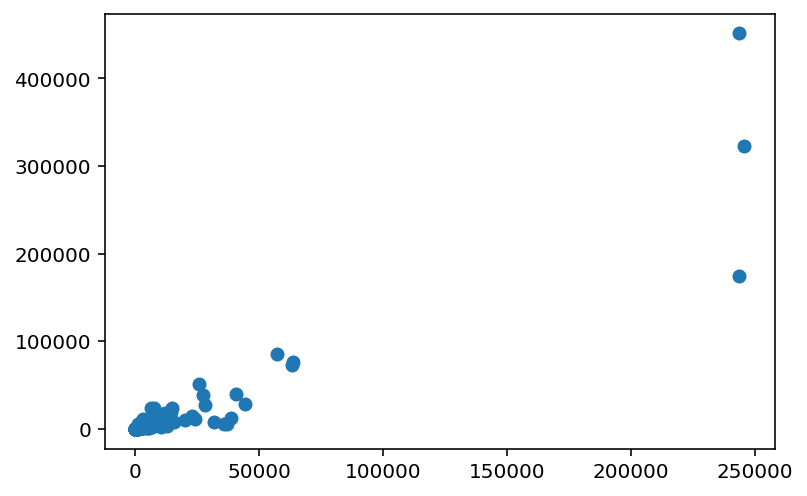

In [77]:
# The scatter plot that shows the relationship between prediction and actual value
plt.scatter(pred_test, y_test)
plt.show()

From the mean absolute errors and scatter plots of the last prediction, we could see that the result improve, but still not satisfactory. The baseline model is not good.

### Final Model

Feature engineering for **StartDate**

In [80]:
# Convert StartDate to YYYY-MM in order to figure out the impact of the starting year and month of the ads
date = combined_data['StartDate'].dt.to_period('M')
combined_data['Start_year_and_month'] = date

/opt/conda/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


Feature engineering for **CountryCode**

In [81]:
north_america = ['united states', 'canada']
south_america = ['chile', 'argentina', 'brazil', 'puerto rico']
europe = ['united kingdom', 'denmark', 'sweden', 'netherlands', 'norway', 'ireland', 'switzerland', 'france', 'belgium', 'finland', 'austria', 'poland', 'lithuania','germany']
africa = ['nigeria', 'south africa']
oceania_australia = ['australia', 'new zealand']
asia = ['iraq', 'kuwait', 'united arab emirates', 'india', 'turkey']

In [82]:
# Replace the country names with the continents they belong to
def get_conti(c):
    if c in asia:
        return "Asia"
    elif c in europe:
        return "Europe"
    elif c in africa:
        return "Africa"
    elif c in oceania_australia:
        return "Oceania/Australia"
    elif c in north_america:
        return "North America"
    elif c in south_america:
        return "South America"

In [83]:
# Insert the result into combined_data
combined_data['Continent'] = combined_data['CountryCode'].apply(lambda x: get_conti(x))

Feature engineering for **AgeBracket**

In [84]:
# extract "AgeBrack" column from combined_data
ages = combined_data['AgeBracket']

# define a helper function to clean the data
def helper_age(age):
    if str(age)[-1] == '-':
        return np.nan
    return age

# Remove the values that only contain the maximum of age
ages = ages.apply(helper_age)

# Get all of the minimums of ages
ages = ages.apply(lambda x: (int(str(x)[:2]) if x is not np.nan else x))

# Get mean
age_mean = ages.mean()

# Imputation using mean
s = pd.Series([age_mean] * len(ages))
ages = ages.fillna(s)

# Add ages to original dataframe
combined_data['Age_min'] = ages

In [397]:
# Dataframe after the feature engineerings
combined_data[['Start_year_and_month', 'Continent', 'Age_min']].head()

,Start_year_and_month,Continent,Age_min
0,2018-10,North America,18.000000
1,2018-09,North America,18.000000
2,2018-10,North America,18.000000
3,2018-09,North America,18.603304
4,2018-10,North America,18.000000


Predict the spend by **Currency Code**, **Impressions**, **OrganizationName**, and **PayingAdvertiserName**

In [44]:
# Extract useful columns
cleaned1 = combined_data[['Currency Code', 'Spend', 'Impressions', 'OrganizationName', 'PayingAdvertiserName']]
cleaned1.head()

,Currency Code,Spend,Impressions,OrganizationName,PayingAdvertiserName
0,USD,4361,397340,Bully Pulpit Interactive,NextGen America
1,USD,11,3309,ACRONYM,Our Lives Our Vote
2,USD,205,31789,Mothership Strategies,Progressive Turnout Project
3,USD,203,94877,Chong and Koster,Everytown for Gun Safety AF
4,USD,558,228469,Penna Powers,Lieutenant Governor's Office


In [139]:
# Perform one-hot encoding on Currency Code column
currency = ['Currency Code']
curr_trans = Pipeline(steps=[('curr-trans', OneHotEncoder(handle_unknown='ignore'))])

# Z-scale the Impressions
impr = ['Impressions']
impr_trans = Pipeline(steps=[('impr-trans', pp.StandardScaler())])

# Perform one-hot encoding on OrganizationName column
org = ['OrganizationName']
org_trans = Pipeline(steps=[('org-trans', OneHotEncoder(handle_unknown='ignore'))])

# Perform one-hot encoding on PayingAdvertiserName column
adver = ['PayingAdvertiserName']
adver_trans = Pipeline(steps=[('adver-trans', OneHotEncoder(handle_unknown='ignore'))])

# Putting them together
preproc1 = ColumnTransformer(transformers=[('curr', curr_trans, currency), ('impr', impr_trans, impr), ('org', org_trans, org), ('adver', adver_trans, adver)])
pl1 = Pipeline(steps=[('preprocessor', preproc1), ('regressor', es.RandomForestRegressor())])

In [50]:
# Make Prediction
X1 = cleaned1.drop('Spend', axis=1)
y1 = cleaned1.Spend

# Train-test split and fit
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.25)
f1 = pl1.fit(X_train1, y_train1)

In [51]:
# Mean absolute error for train data
pred1 = pl1.predict(X_train1)
scr1 = mean_absolute_error(y_train1, pred1)
scr1

264.5725564927627

In [52]:
# Mean absolute error for test data
pred_test1 = pl1.predict(X_test1)
scr_test1 = mean_absolute_error(y_test1, pred_test1)
scr_test1
# This error is lower than the error of baseline model. So Currency Code could improve prediction

751.290308028741

Predict the spend by **Start_year_and_month**, **Impressions**, **OrganizationName**, and **PayingAdvertiserName**

In [53]:
# Extract useful columns
cleaned2 = combined_data[['Spend', 'Impressions', 'Start_year_and_month', 'OrganizationName', 'PayingAdvertiserName']]
cleaned2.head()

,Spend,Impressions,Start_year_and_month,OrganizationName,PayingAdvertiserName
0,4361,397340,2018-10,Bully Pulpit Interactive,NextGen America
1,11,3309,2018-09,ACRONYM,Our Lives Our Vote
2,205,31789,2018-10,Mothership Strategies,Progressive Turnout Project
3,203,94877,2018-09,Chong and Koster,Everytown for Gun Safety AF
4,558,228469,2018-10,Penna Powers,Lieutenant Governor's Office


In [138]:
# Perform one-hot encoding on Start_year_and_month column
date = ['Start_year_and_month']
date_trans = Pipeline(steps=[('date-trans', OneHotEncoder(handle_unknown='ignore'))])

In [60]:
# Putting them together
preproc2 = ColumnTransformer(transformers=[('date', date_trans, date), ('impr', impr_trans, impr), ('org', org_trans, org), ('adver', adver_trans, adver)])
pl2 = Pipeline(steps=[('preprocessor', preproc2), ('regressor', es.RandomForestRegressor())])

In [61]:
# Make Prediction
X2 = cleaned2.drop('Spend', axis=1)
y2 = cleaned2.Spend

# Train-test split and fit
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.25)
f2 = pl2.fit(X_train2, y_train2)

In [62]:
# Mean absolute error for train data
pred2 = pl2.predict(X_train2)
scr2 = mean_absolute_error(y_train2, pred2)
scr2

276.2378725398313

In [63]:
# Mean absolute error for test data
pred_test2 = pl2.predict(X_test2)
scr_test2 = mean_absolute_error(y_test2, pred_test2)
scr_test2
# This error is lower than the error of baseline model. So start_year_and_month could improve prediction

767.8701030927836

Predict the spend by **Age_min**, **Impressions**, **OrganizationName**, and **PayingAdvertiserName**

In [101]:
# Extract useful columns
cleaned3 = combined_data[['Age_min', 'Impressions', 'Spend', 'OrganizationName', 'PayingAdvertiserName']]
cleaned3.head()

,Age_min,Impressions,Spend,OrganizationName,PayingAdvertiserName
0,18.000000,397340,4361,Bully Pulpit Interactive,NextGen America
1,18.000000,3309,11,ACRONYM,Our Lives Our Vote
2,18.000000,31789,205,Mothership Strategies,Progressive Turnout Project
3,18.603304,94877,203,Chong and Koster,Everytown for Gun Safety AF
4,18.000000,228469,558,Penna Powers,Lieutenant Governor's Office


In [102]:
# put them together using columntransformer
preproc3 = ColumnTransformer(transformers=[('impr', impr_trans, impr), ('org', org_trans, org), ('adver', adver_trans, adver)])
pl3 = Pipeline(steps=[('preprocessor', preproc3), ('regressor', es.RandomForestRegressor())])

In [103]:
# Make Prediction
X3 = cleaned3.drop('Spend', axis=1)
y3 = cleaned3.Spend

# Train-test split and fit
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.25)
f3 = pl3.fit(X_train3, y_train3)

In [104]:
# Mean absolute error for train data
pred3 = pl3.predict(X_train3)
scr3 = mean_absolute_error(y_train3, pred3)
scr3

272.64709059668854

In [105]:
# Mean absolute error for test data
pred_test3 = pl3.predict(X_test3)
scr_test3 = mean_absolute_error(y_test3, pred_test3)
scr_test3
# This error is larger than the error of baseline model. So age_min cannot improve prediction

1030.4013874905163

Predict the spend by **Gender**, **Impressions**, **OrganizationName**, and **PayingAdvertiserName**

In [106]:
# First fill all NaNs with 'All genders'
combined_data['Gender'] = combined_data['Gender'].replace(np.nan, 'All genders')
combined_data.head()

,ADID,CreativeUrl,Currency Code,Spend,Impressions,StartDate,EndDate,OrganizationName,BillingAddress,CandidateBallotInformation,...,Language,AdvancedDemographics,Targeting Connection Type,Targeting Carrier (ISP),CreativeProperties,Start_year_and_month,Continent,Age_min,is_large,prediction
0,6bf6eca7297551f35a5d17b478cedb6683a75c2f9b9b00...,https://www.snap.com/political-ads/asset/27e1c...,USD,4361,397340,2018-10-18 15:45:57+00:00,2018-11-06 23:00:00+00:00,Bully Pulpit Interactive,"1445 New York Ave NW,Washington,20005,US",NaN,...,NaN,NaN,NaN,NaN,NaN,2018-10,North America,18.000000,large,2986.00
1,a801fccc059ac401a54ae3bf309f3b2a22c35df0392666...,https://www.snap.com/political-ads/asset/e1b1d...,USD,11,3309,2018-09-25 05:00:00+00:00,2018-09-26 05:00:00+00:00,ACRONYM,US,NaN,...,NaN,NaN,NaN,NaN,web_view_url:https://ourlivesourvote.com/regis...,2018-09,North America,18.000000,small,11.38
2,a19bd9f5379e7affc4586d26537346142cc3a8a487b3a3...,https://www.snap.com/political-ads/asset/75251...,USD,205,31789,2018-10-30 17:58:01+00:00,2018-11-06 22:59:59+00:00,Mothership Strategies,"1328 Florida Avenue NW, Building C, Washington...",NaN,...,NaN,NaN,NaN,NaN,web_view_url:http://votingmatters.org/,2018-10,North America,18.000000,small,159.34
3,b30c9d008f67f84a14dbb79166f4f1da04d27bea85b3e4...,https://www.snap.com/political-ads/asset/60ab9...,USD,203,94877,2018-09-28 20:33:08+00:00,NaT,Chong and Koster,"1640 Rhode Island Ave. NW, Suite 600,Washingto...",NaN,...,en,NaN,NaN,NaN,web_view_url:https://act.everytown.org/sign/di...,2018-09,North America,18.603304,large,268.24
4,dfb3bfcd72700889fd7f579bdae86a6c11f2efdede5d78...,https://www.snap.com/political-ads/asset/a72b6...,USD,558,228469,2018-10-09 15:51:44+00:00,2018-11-07 03:00:00+00:00,Penna Powers,"1706 s major street,salt lake city,84115,US",NaN,...,NaN,NaN,NaN,NaN,NaN,2018-10,North America,18.000000,large,619.11


In [107]:
# Extract useful columns
cleaned4 = combined_data[['Spend', 'Impressions', 'Gender', 'OrganizationName', 'PayingAdvertiserName']]
cleaned4.head()

,Spend,Impressions,Gender,OrganizationName,PayingAdvertiserName
0,4361,397340,All genders,Bully Pulpit Interactive,NextGen America
1,11,3309,All genders,ACRONYM,Our Lives Our Vote
2,205,31789,All genders,Mothership Strategies,Progressive Turnout Project
3,203,94877,All genders,Chong and Koster,Everytown for Gun Safety AF
4,558,228469,All genders,Penna Powers,Lieutenant Governor's Office


In [137]:
# Perform one-hot encoding on Gender column
gender = ['Gender']
gender_trans = Pipeline(steps=[('gender-trans', OneHotEncoder(handle_unknown='ignore'))])

In [113]:
# Putting them together
preproc4 = ColumnTransformer(transformers=[('gender', gender_trans, gender), ('impr', impr_trans, impr), ('org', org_trans, org), ('adver', adver_trans, adver)])
pl4 = Pipeline(steps=[('preprocessor', preproc4), ('regressor', es.RandomForestRegressor())])

In [114]:
# Make Prediction
X4 = cleaned4.drop('Spend', axis=1)
y4 = cleaned4.Spend

# Train-test split and fit
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.25)
f4 = pl4.fit(X_train4, y_train4)

In [115]:
# Mean absolute error for train data
pred4 = pl4.predict(X_train4)
scr4 = mean_absolute_error(y_train4, pred4)
scr4

272.2755050876958

In [112]:
# Mean absolute error for test data
pred_test4 = pl4.predict(X_test4)
scr_test4 = mean_absolute_error(y_test4, pred_test4)
scr_test4
# This error is larger than the error of baseline model. So Gender cannot improve prediction

1101.2433561387068

Predict the spend by **Continent**, **Impressions**, **OrganizationName**, and **PayingAdvertiserName**

In [128]:
# Extract useful columns
cleaned5 = combined_data[['Spend', 'Impressions', 'Continent', 'OrganizationName', 'PayingAdvertiserName']]
cleaned5.head()

,Spend,Impressions,Continent,OrganizationName,PayingAdvertiserName
0,4361,397340,North America,Bully Pulpit Interactive,NextGen America
1,11,3309,North America,ACRONYM,Our Lives Our Vote
2,205,31789,North America,Mothership Strategies,Progressive Turnout Project
3,203,94877,North America,Chong and Koster,Everytown for Gun Safety AF
4,558,228469,North America,Penna Powers,Lieutenant Governor's Office


In [322]:
# One-hot encoding for continent
conti = ['Continent']
cont_trans = Pipeline(steps=[('cont-trans', OneHotEncoder(handle_unknown='ignore'))])

In [323]:
# Putting them together
preproc5 = ColumnTransformer(transformers=[('cont', cont_trans, conti), ('impr', impr_trans, impr), ('org', org_trans, org), ('adver', adver_trans, adver)])
pl5 = Pipeline(steps=[('preprocessor', preproc5), ('regressor', es.RandomForestRegressor())])

In [324]:
# Make Prediction
X5 = cleaned5.drop('Spend', axis=1)
y5 = cleaned5.Spend

# Train-test split and fit
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size=0.25)
f5 = pl5.fit(X_train5, y_train5)

In [325]:
# Mean absolute error for train data
pred5 = pl5.predict(X_train5)
scr5 = mean_absolute_error(y_train5, pred5)
scr5

255.04938769134645

In [326]:
# Mean absolute error for test data
pred_test5 = pl5.predict(X_test5)
scr_test5 = mean_absolute_error(y_test5, pred_test5)
scr_test5
# This error is lower than the error of baseline model. So continent improves prediction

689.2604467353952

Predict the spend by **Currency Code**, **Continent**, **Start_year_and_month**, **Impressions**, **OrganizationName**, and **PayingAdvertiserName**

In [317]:
# Extract useful columns
cleaned6 = combined_data[['Currency Code', 'Spend', 'Impressions', 'Start_year_and_month', 'OrganizationName', 'PayingAdvertiserName', 'Continent']]
cleaned6.head()

,Currency Code,Spend,Impressions,Start_year_and_month,OrganizationName,PayingAdvertiserName,Continent
0,USD,4361,397340,2018-10,Bully Pulpit Interactive,NextGen America,North America
1,USD,11,3309,2018-09,ACRONYM,Our Lives Our Vote,North America
2,USD,205,31789,2018-10,Mothership Strategies,Progressive Turnout Project,North America
3,USD,203,94877,2018-09,Chong and Koster,Everytown for Gun Safety AF,North America
4,USD,558,228469,2018-10,Penna Powers,Lieutenant Governor's Office,North America


In [377]:
# Putting them together
preproc6 = ColumnTransformer(transformers=[('cont', cont_trans, conti),('curr', curr_trans, currency), ('impr', impr_trans, impr), ('org', org_trans, org), ('adver', adver_trans, adver), ('date', date_trans, date)])
pl6 = Pipeline(steps=[('preprocessor', preproc6), ('regressor', es.RandomForestRegressor())])

In [385]:
# Make Prediction
X6 = cleaned6.drop('Spend', axis=1)
y6 = cleaned6.Spend

# Train-test split and fit
X_train6, X_test6, y_train6, y_test6 = train_test_split(X6, y6, test_size=0.25)
f6 = pl6.fit(X_train6, y_train6)

In [362]:
# Mean absolute error for train data
pred6 = pl6.predict(X_train6)
scr6 = mean_absolute_error(y_train6, pred6)
scr6

257.25404779756326

In [350]:
# Mean absolute error for test data
pred_test6 = pl6.predict(X_test6)
scr_test6 = mean_absolute_error(y_test6, pred_test6)
scr_test6

580.3565827196858

The last model has the lowest mean absolute error, so we use it as our final model.

### Fairness Evaluation

In [386]:
# Split data into two groups based on impressions
combined_data['is_large'] = (combined_data.Impressions <= 75000).replace({True:'small', False:'large'})

In [387]:
# Use final model to make predictions
prediction = pl6.predict(X6)
prediction

array([3304.37,   12.3 ,  186.12, ...,    0.  ,   70.85, 2259.06])

In [388]:
# Add a column contains predictions
combined_data['prediction'] = prediction

In [389]:
# r-2 score for two groups
(
    combined_data
    .groupby('is_large')
    .apply(lambda x: metrics.r2_score(x.Spend, x.prediction))
    .rename('r2_score')
    .to_frame()
)

,r2_score
is_large,
large,0.926983
small,0.898939


In [390]:
# Permutation test
obs = combined_data.groupby('is_large').apply(lambda x: metrics.r2_score(x.Spend, x.prediction)).diff().iloc[-1]

metrs = []
for _ in range(1000):
    s = (
        combined_data[['is_large', 'prediction', 'Spend']]
        .assign(is_large=combined_data.is_large.sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('is_large')
        .apply(lambda x: metrics.r2_score(x.Spend, x.prediction))
        .diff()
        .iloc[-1]
    )
    
    metrs.append(s)


0.379


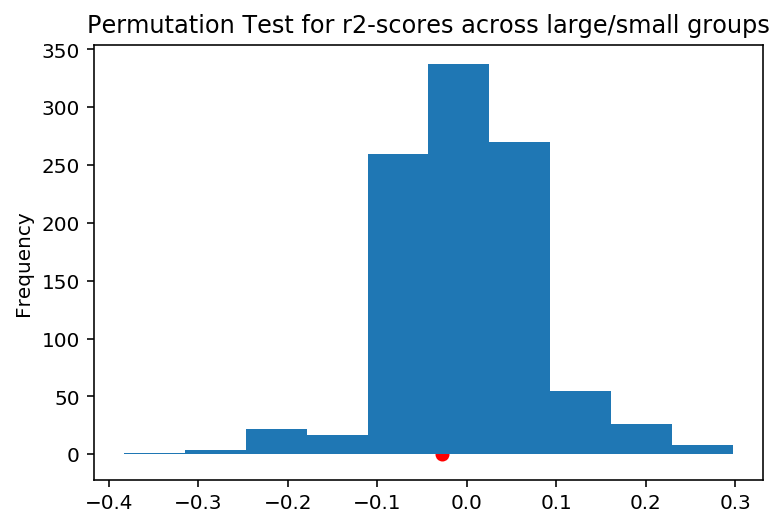

In [391]:
print(pd.Series(metrs <= obs).mean())
pd.Series(metrs).plot(kind='hist', title='Permutation Test for r2-scores across large/small groups')
plt.scatter(obs, 0, c='r');

Therefore, we cannot reject the null hypothesis. The distributions of r2-scores for large and small groups are similar.